# Censored Regressors with Pyro GP Module: 1D test functions, Gaussian derived likelihoods and RBF kernel

This notebook provides a basic toolbox for the Gaussian processess framework implementation in pyro.contrib.gp module for censored regressor problem

In [253]:
!pip install -q pyro-ppl

In [254]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

import tqdm

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

In [255]:
import numpy as np
import matplotlib.pyplot as plt

# Data Generation

## 1. 1-D Test Functions

We generate the different 1-D data points from a various test functions.
The test function is specifed in the dictionary and the parameters to specify are:
 * `start`: the lower bound of the interval from which we sample the x-axis grid   
 * `end`: the upper bound of the interval from which we sample the x-axis grid
 * `num_of_points`: num of equidistant points to cover the x-axis grid
 * `num_of_points_tes`: num of equdistant points for the x-axis grid in which we evaluate the predicted function
 * `padding`: length of the intraval added to lower and upper bound to extend the train x-axis grid, its used for testing and measuring the ability of the model to extrapolate outside the training regions  

In [256]:
# define function in the torch specific way
fcn1 = lambda x: 0.5 * torch.sin(3 * x)
fcn2 = lambda x: torch.pow((6 * x - 2),2)* torch.sin(2 * (6 * x - 2))
fcn3 = lambda x: torch.Tensor(x) * torch.sin(x)

fcn_dict = {
    # label, [start, end, num_of_points, num_of_points_test, padding for test region ], fcn
    'fcn1': ["$f(x) = 0.5 \sin(3x)$", [0, 5, 20, 500, 0.5], fcn1],
    'fcn2': ["$f(x) = (6x - 2)^2 \sin[2(6x - 2)]$", [0, 1, 30, 500, 0.5], fcn2],
    'fcn3': ["$f(x) = x \sin(x)$", [0, 10, 1000, 500, 0.5], fcn3]
    }

In [298]:
# set hyperparameters for data generation

fcn_key_ = 'fcn3' # select function
noise_std = 0.2 # dd noise
N = 30 # number of training data points

# set perscentile corresponding to the treshold --> values smaller than given treshold are assigned treshold value
treshold = 25

__Generated variables__

*   variable X is x-axis grid over which the values of the function f(x) are being computed  
*   variable y correspond to f(x) values
* (X_train, y_train) is uniformly subsampled N points used for training
* (X_train, y_train_noise) is uniformly subsampled N points used for training with mixed in Gaussian noise with variance specified in variable noise_std
* X_test is x-grid which has extra padding on both side outside the train interval to test the ability of the model to extrapolate
* (X_test, y_test) fucntion f(x) computed on the testing interval X_test

In [299]:
# generate data
# get grid
X = np.linspace(
    start=fcn_dict[fcn_key_][1][0],
    stop=fcn_dict[fcn_key_][1][1],
    num=fcn_dict[fcn_key_][1][2]).reshape(-1, 1)

# apply selected function
temp_y = fcn_dict[fcn_key_][2](torch.Tensor(X))
y = np.squeeze(temp_y.numpy())

# sample training set
X_train = dist.Uniform(fcn_dict[fcn_key_][1][0], fcn_dict[fcn_key_][1][1]).sample(sample_shape=(N,))
y_train = fcn_dict[fcn_key_][2](torch.Tensor(X_train))
# mix in normal noise
y_train_noisy = y_train + dist.Normal(0.0, noise_std).sample(sample_shape=(N,))

X_test = np.squeeze(np.linspace(
    start=fcn_dict[fcn_key_][1][0] - fcn_dict[fcn_key_][1][4],
    stop=fcn_dict[fcn_key_][1][1] + fcn_dict[fcn_key_][1][4],
    num=fcn_dict[fcn_key_][1][3]))

temp_y_test = fcn_dict[fcn_key_][2](torch.Tensor(X_test))
y_test = np.squeeze(temp_y_test.numpy())

__Censoring__
* compute bound for a given percentile and replaces all values smaller than the bound with the bound value
* `censoring_id` is an identifier indicating positions of the values on which the censoring was applied  

In [300]:
# apply censoring
lower_cf = np.percentile(y_train, treshold)
print(lower_cf)
y_train_censored = np.clip(y_train, lower_cf, None)
y_train_noisy_censored = np.clip(y_train_noisy, lower_cf, None)
censoring_id = np.zeros(len(y_train))
np.put(censoring_id, np.where(y_train_censored!=y_train), 1)

-0.8728168211101629


In [301]:
y_train

tensor([ 1.2992e+00,  6.0460e+00,  2.8859e-01,  5.3742e+00,  2.0967e-03,
        -3.1245e+00,  7.7887e+00,  1.4793e+00,  2.7535e-01,  3.1362e+00,
        -4.4757e+00,  8.7278e-01,  7.8263e+00,  1.8311e+00,  4.0771e-01,
         3.8470e+00, -4.5665e+00,  8.5804e-01, -2.1358e+00, -4.3018e+00,
         6.1339e+00, -1.8557e+00, -9.4008e-01,  2.5122e+00,  1.2259e+00,
        -6.7102e-01,  3.2462e+00, -4.7578e-01,  7.8535e+00, -4.8116e+00])

In [261]:
y_train_censored

tensor([-2.6412,  5.0529, -4.4604,  1.9851,  1.0725,  7.8984,  1.7448, -1.2680,
        -2.6317,  0.7389, -4.4525,  1.7337, -1.4196, -0.3986, -4.4604, -4.2054,
        -3.2678,  1.8188,  2.3875,  7.8486,  1.8120,  3.1503,  0.9766, -4.4604,
         1.7440, -3.5995, -2.3306,  3.4843,  6.8647,  1.7327])

In [302]:
censoring_id

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.])

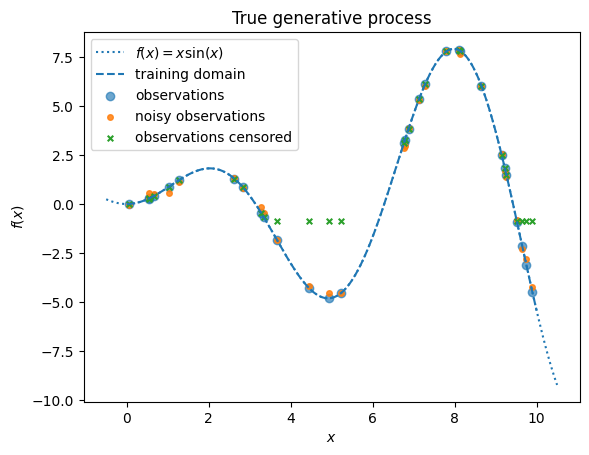

In [303]:
plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
plt.plot(X, y, label='training domain', linestyle="dashed", color=sns.color_palette()[0])
plt.scatter(X_train, y_train, label="observations",  alpha=0.65, color=sns.color_palette()[0])
plt.scatter(X_train, y_train_noisy, label="noisy observations", s=16, alpha=0.85, color=sns.color_palette()[1])
plt.scatter(X_train, y_train_censored, label="observations censored", s=16, color=sns.color_palette()[2], marker='x')

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

# Experiments

In [304]:
def is_var(model):
  if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP:
    res = True
  else:
    res = False
  return res

def optimise(model, num_steps = 2000, lr_=0.005, MeanFieldElbo=False):
  pyro.clear_param_store()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr_)
  if MeanFieldElbo==True:
      loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
  else:
      loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

  losses = []
  variances = []
  lengthscales = []
  noises = []

  pbar = tqdm.tqdm(range(num_steps), position=0, leave=True)

  for epoch in pbar:
      variances.append(model.kernel.variance.item())
      lengthscales.append(model.kernel.lengthscale.item())
      if is_var(model)==True:
        noises.append(model.likelihood.variance.item())
      else:
        noises.append(model.noise.item())

      optimizer.zero_grad()
      loss = loss_fn(model.model, model.guide)
      loss.backward()
      optimizer.step()

      losses.append(loss.item())

  model.set_mode("guide")
  print("\nvariance = {: .6f}".format(model.kernel.variance))
  print("lengthscale = {: .6f}".format(model.kernel.lengthscale))
  if is_var(model)==True:
    print("noise = {: .6f}".format(model.likelihood.variance))
  else:
    print("noise = {: .6f}".format(model.noise))
  res = {'model': model,
          'losses' : losses,
          'variances' : variances,
          'lengthscales' : lengthscales,
          'noises' : noises}
  return res

In [330]:
def visualise_training(losses, variances, lengthscales, noises):
  fig, ax = plt.subplots(1, 4, figsize=(15, 3))
  ax[0].plot(losses)
  ax[0].set_title('loss')
  ax[1].plot(variances)
  ax[1].set_title('variance')
  ax[2].plot(lengthscales)
  ax[2].set_title('lengthscales')
  ax[3].plot(noises)
  ax[3].set_title('noise parameter')

def mse(predicted, labels):
    res = torch.mean((predicted - labels) ** 2)
    return res

def rmse(predicted, labels):
    res = torch.sqrt(mse(predicted, labels))
    return res

def visualise_results(model, grid=X_train, labels=y_train, censored=None, title_=' '):
  with torch.no_grad():
    mean, cov = model.forward(torch.Tensor(X_test), full_cov=True)
    mean_train, cov_train = model.forward(torch.Tensor(X_train), full_cov=True)
  sd = cov.diag().sqrt().numpy()
  rmse_train = rmse(mean_train, torch.Tensor(y_train)).numpy()
  rmse_test = rmse(mean, torch.Tensor(y_test)).numpy()

  title_ = '{}\nrmse train: {: .4f}, rmse test: {: .4f}'.format(title_, rmse_train, rmse_test)
  plt.plot(X_test, y_test, label=fcn_dict[fcn_key_][0], linestyle="dotted")
  plt.scatter(X_train, y_train, label="Observations")
  plt.plot(X_test, mean.numpy(), label="Mean prediction")
  if censored is not None:
    plt.scatter(X_train, censored, label="noisy observations", s=16, alpha=0.85, color=sns.color_palette()[2], marker='x')
  plt.fill_between(
      X_test.ravel(),
      mean.numpy() - 1.96 * sd,
      mean.numpy() + 1.96 * sd,
      alpha=0.3,
      label=r"95% confidence interval",
  )
  plt.legend()
  plt.xlabel("$x$")
  plt.ylabel("$f(x)$")
  _ = plt.title(title_)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


def  is_var(model):
  if type(model) == gp.models.VariationalSparseGP or type(model) == gp.models.VariationalGP:
    res = True
  else:
    res = False
  return res


def visualise_trajectories(model, fcn_key_, samples):
  num_test_grid = fcn_dict[fcn_key_][1][3]
  noise = (model.likelihood.variance if is_var(model) else model.noise)
  cov = kernel.forward(torch.Tensor(X_test)) + noise.expand(num_test_grid).diag()
  samples = dist.MultivariateNormal(
              torch.zeros(num_test_grid), covariance_matrix=cov).sample(sample_shape=(samples,))
  fig, ax = plt.subplots(figsize=(8, 3))
  _ = ax.plot(X_test, samples.T, lw=2, alpha=0.4)
  _ = plt.title('variance: {: .4f}, lengthscale: {: .4f}'.format(model.kernel.variance.item(), model.kernel.lengthscale.item()))

In [306]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter
from torch import nn

import pyro
import pyro.distributions as dist
from pyro.nn.module import PyroParam, pyro_method
from pyro.contrib.gp.models import VariationalGP, SparseGPRegression
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like

## 1. GPRegression

This section is used for testing the performance of the `gp.models.GPRegression` object on the on the non-censored and censored data to provide the intuition into the impact of the censoring.

This object does not allow for custom likelihood and supports only internaly implemeneted Gaussian likelihood.

### Non-censored data
The benchmark values for the GP if the data were observed fully.

In [307]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train), kernel)

gpr_res = optimise(gpr)

100%|██████████| 2000/2000 [00:05<00:00, 367.62it/s]


variance =  190.276912
lengthscale =  2.547831
noise =  0.000005


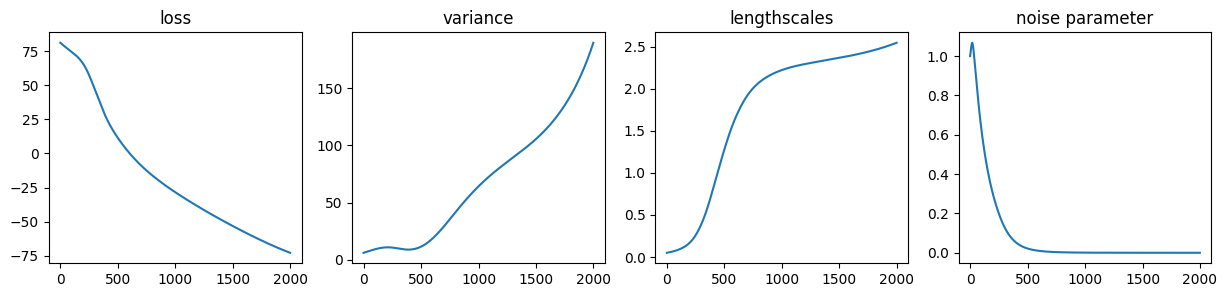

In [308]:
visualise_training(gpr_res['losses'], gpr_res['variances'], gpr_res['lengthscales'], gpr_res['noises'])

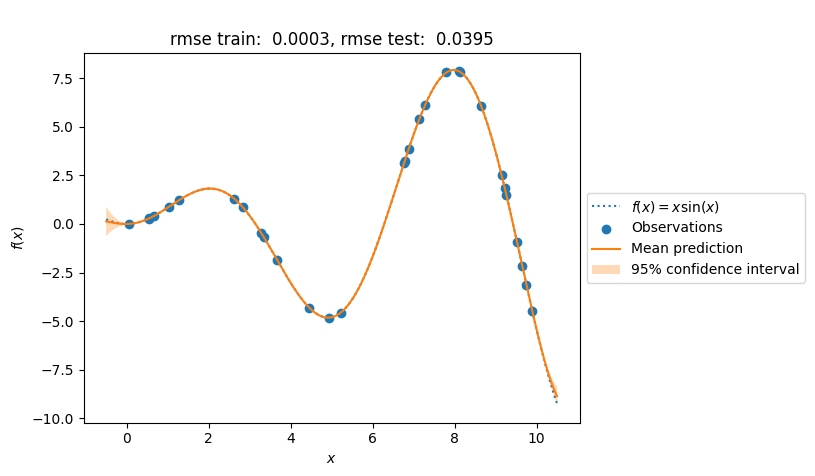

In [326]:
visualise_results(gpr)

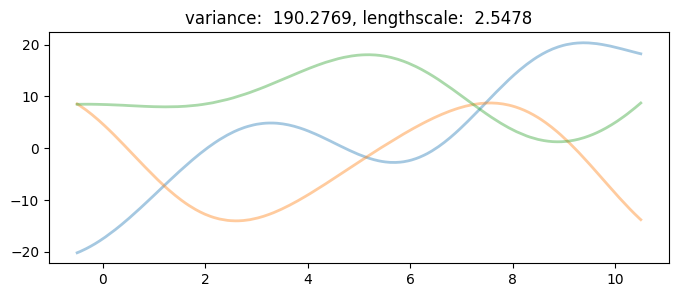

In [310]:
visualise_trajectories(gpr, fcn_key_, 3)

### Censored data

Applying "wrong modelling approach" to the censored data, i.e. neglecting the censoring.

In [311]:
kernel_censored = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr2 = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel_censored)
gpr2_res = optimise(gpr2)

100%|██████████| 2000/2000 [00:06<00:00, 300.73it/s]


variance =  8.831780
lengthscale =  0.855433
noise =  0.024786


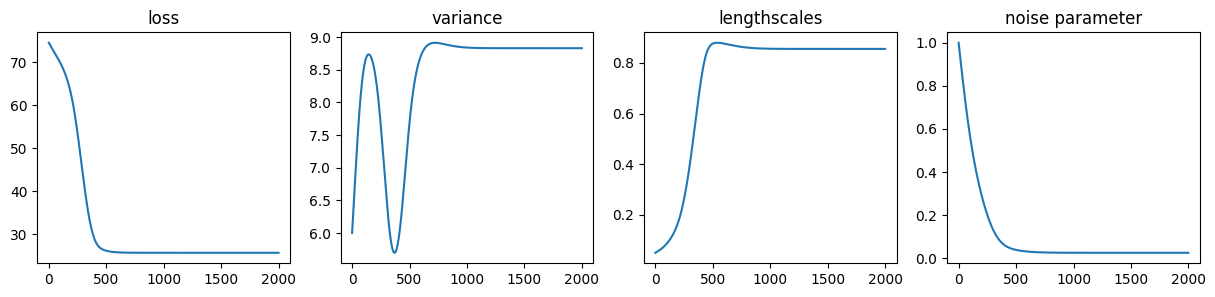

In [312]:
visualise_training(gpr2_res['losses'], gpr2_res['variances'], gpr2_res['lengthscales'], gpr2_res['noises'])

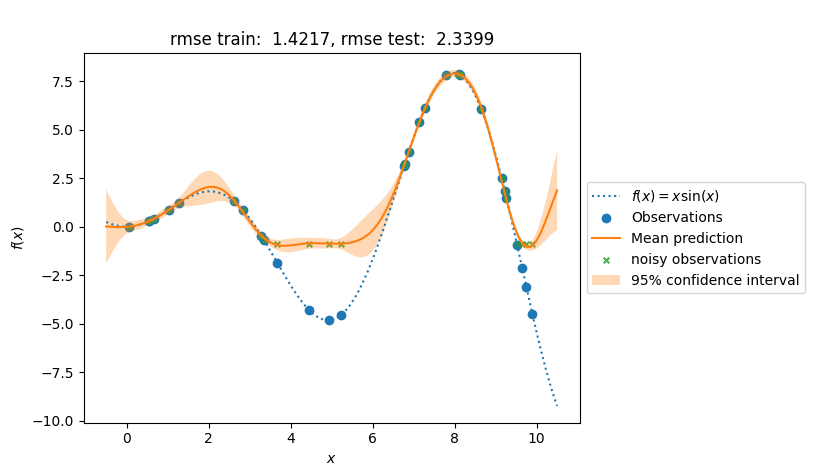

In [331]:
visualise_results(gpr2, censored=y_train_censored)

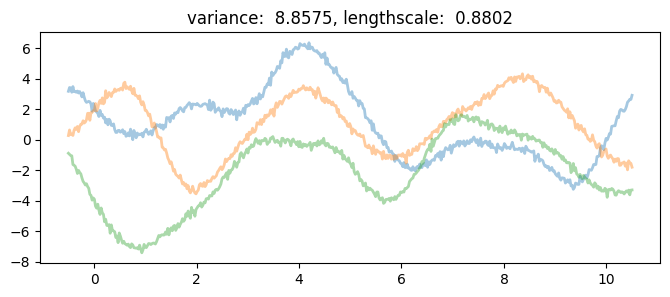

In [332]:
visualise_trajectories(gpr2, fcn_key_, 3)

### Censored + noise

Impact of the perturbations within the observed censored values.

In [333]:
kernel_censored_noise = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(var_), lengthscale=torch.tensor(lengthscale_))
gpr3 = gp.models.GPRegression(torch.Tensor(X_train), torch.Tensor(y_train_noisy_censored), kernel_censored_noise)

gpr3_res = optimise(gpr3)

100%|██████████| 2000/2000 [00:05<00:00, 368.92it/s]


variance =  8.857513
lengthscale =  0.880199
noise =  0.034028


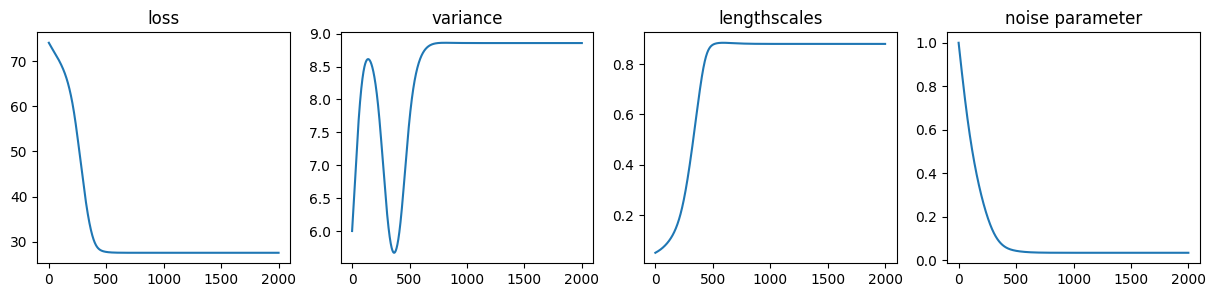

In [334]:
visualise_training(gpr3_res['losses'], gpr3_res['variances'], gpr3_res['lengthscales'], gpr3_res['noises'])

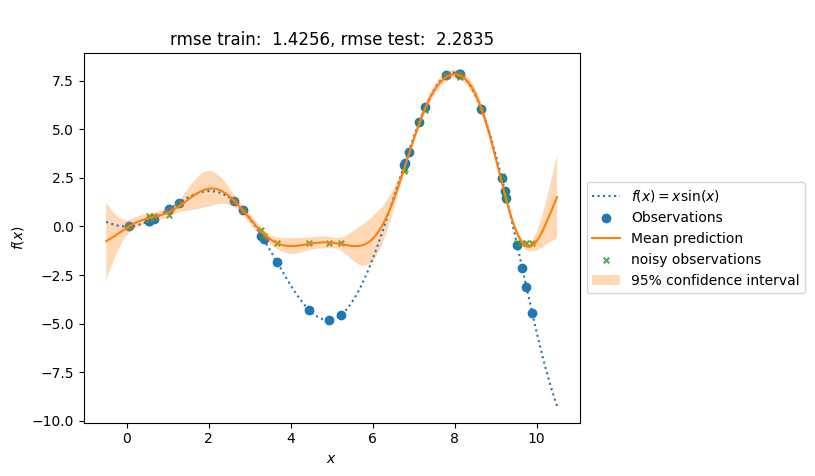

In [335]:
visualise_results(gpr3, censored=y_train_noisy_censored)

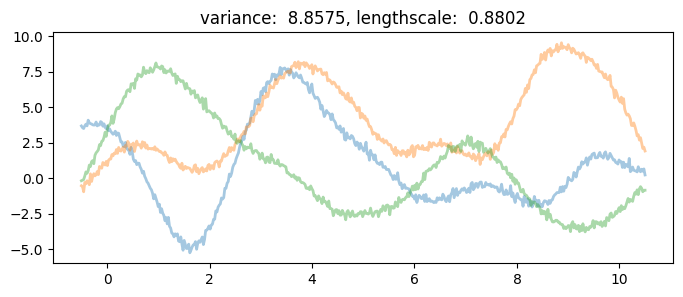

In [336]:
visualise_trajectories(gpr3, fcn_key_, 3)

## Custom Likelihood

This section uses object `VariationalGP` which supports usage of custom likelihoods.

 * We first check the performance for the Gaussian likelihood to understand the impact of choosing `VariationalGP` object instead of `GPRegressor`.
 * Then we apply explore using Censored Gaussian implementation.

In [279]:
from torch.distributions.exp_family import ExponentialFamily
from pyro.distributions.torch_distribution import TorchDistributionMixin
from torch.distributions.utils import _standard_normal, broadcast_all

from numbers import Number, Real
import math
import tensorflow as tf
import tensorflow_probability as tfp

class PyroCensoredNormal(ExponentialFamily, TorchDistributionMixin):
""" this is a modification of the pytorch normal distribution implementation
  the censoring is a vector of 0 and 1 where 1 indicates the position in the input data vector,
  where censoring has been applied"""

    arg_constraints = {'loc': constraints.real, 'scale': constraints.positive}
    support = constraints.real
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        return self.loc

    @property
    def stddev(self):
        return self.scale

    @property
    def variance(self):
        return self.stddev.pow(2)

    def __init__(self, loc, scale, censoring, validate_args=None):

        self.loc, self.scale, self.censoring = broadcast_all(loc, scale, censoring)

        if isinstance(loc, Number) and isinstance(scale, Number) and isinstance(censoring, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.loc.size()
        super(PyroCensoredNormal, self).__init__(batch_shape, validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(PyroCensoredNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        new.loc = self.loc.expand(batch_shape)
        new.scale = self.scale.expand(batch_shape)
        new.censoring = self.censoring
        super(PyroCensoredNormal, new).__init__(batch_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def log_prob(self, value):
        # this is where the censoring is applied
        self.threshold = self.censoring==1
        if self._validate_args:
            self._validate_sample(value)
        # compute the variance
        var = (self.scale ** 2)
        log_scale = math.log(self.scale) if isinstance(self.scale, Number) else self.scale.log()
        log_prob = -((value - self.loc) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))

        # the censored points are assigned the probability value instead of density
        log_prob[self.threshold] = math.log(1 - self.cdf(value)[self.threshold] + 1e-6) if isinstance(1 - self.cdf(value)[self.threshold] + 1e-6,
                                                                                                                       Number) else (1 - self.cdf(value)[self.threshold] + 1e-6).log()
        return log_prob

    def cdf(self, value):

        if self._validate_args:
            self._validate_sample(value)
        return 0.5 * (1 + torch.erf((value - self.loc) * self.scale.reciprocal() / math.sqrt(2)))

In [280]:
from pyro.contrib.gp.likelihoods.likelihood import Likelihood
from pyro.nn.module import PyroParam, pyro_method

class Gaussian(Likelihood):
    def __init__(self, variance=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)

    def forward(self, f_loc, f_var, y=None):
        y_dist = dist.Normal(f_loc + torch.randn(f_loc.dim(), device=f_loc.device)*f_var, self.variance.sqrt())
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample(self._pyro_get_fullname("y"), y_dist, obs=y)


class CensoredHomoscedGaussian(Likelihood):

    def __init__(self, variance=None, censoring=None):
        super().__init__()

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)
        self.censoring = censoring

    def forward(self, f_loc, f_var, y=None):
        y_dist = PyroCensoredNormal(loc=f_loc + torch.randn(f_loc.dim(), device=f_loc.device)*f_var, scale=self.variance.sqrt(), censoring=self.censoring)
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample("y", y_dist, obs=y)


class CensoredHeteroscedGaussian(Likelihood):

    def __init__(self, variance=None, censoring=None):
        super().__init__()

        self.censoring = censoring
        self.softplus = torch.nn.Softplus()

    def forward(self, f_loc, f_var, g_loc, g_var, y=None):
        scale = g_loc + torch.randn(g_loc.size(), device=g_loc.device)*g_var
        y_dist = PyroCensoredNormal(loc=f_loc + torch.randn(f_loc.size(), device=f_loc.device)*f_var, scale=self.softplus(scale), censoring=self.censoring)
        self.y_dist = y_dist
        if y is not None:
            y_dist = y_dist.expand_by(y.shape[:-f_loc.dim()]).to_event(y.dim())
        return pyro.sample("y", y_dist, obs=y)


### Gaussian

In [337]:
likelihood = gp.likelihoods.Gaussian()
likelihood2 = Gaussian()
likelihood3 = CensoredHomoscedGaussian(censoring=torch.from_numpy(censoring_id))

In [338]:
# set parameters for RBF kernel
var_ = 6.
lengthscale_ = 0.05

In [339]:
kernel1 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp1 = VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel=kernel1, likelihood=likelihood2, whiten=True, jitter=1e-06)

In [340]:
vgp1_res = optimise(vgp1, 4000)

100%|██████████| 4000/4000 [00:20<00:00, 190.67it/s]


variance =  5.301859
lengthscale =  1.003002
noise =  0.130773


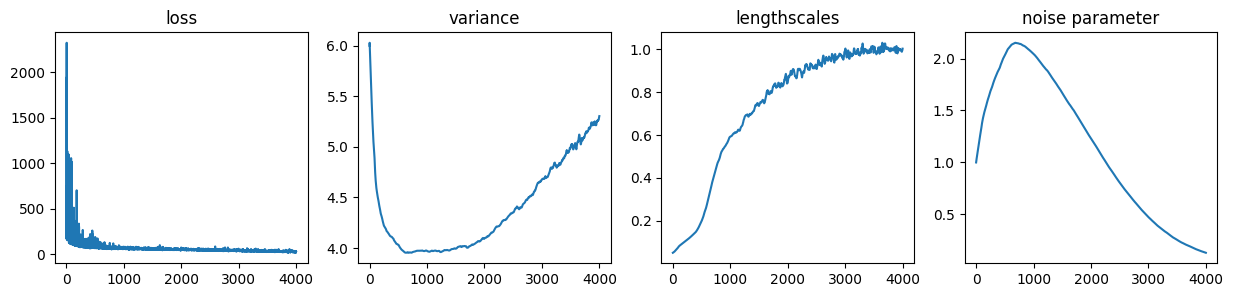

In [341]:
visualise_training(vgp1_res['losses'], vgp1_res['variances'], vgp1_res['lengthscales'], vgp1_res['noises'])

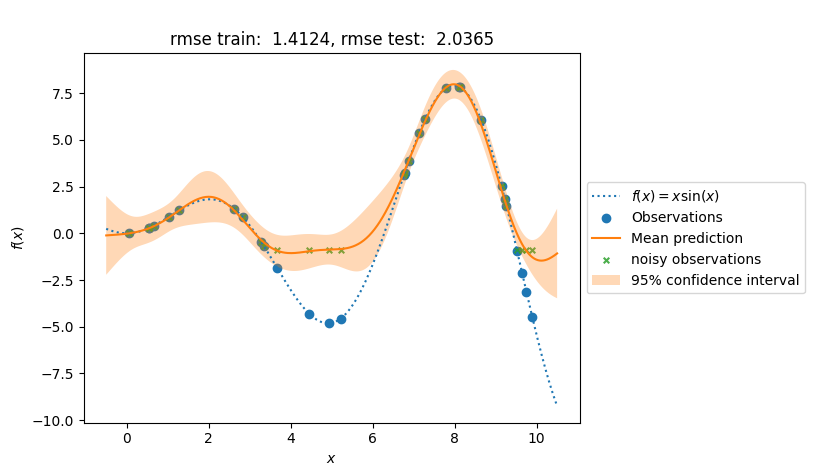

In [344]:
visualise_results(vgp1, censored=y_train_censored)

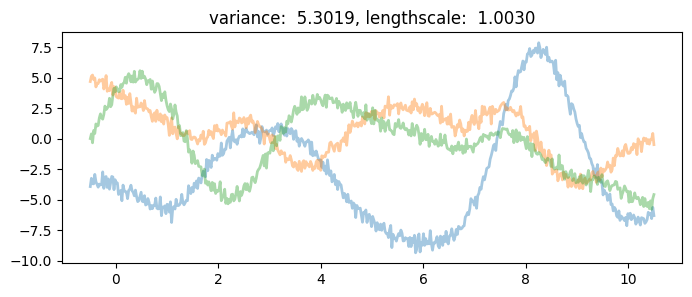

In [346]:
visualise_trajectories(vgp1, fcn_key_, 3)

### Censored Gaussian

* two different implementations of ELBO: `pyro.infer.TraceMeanField_ELBO()` and `pyro.infer.Trace_ELBO()`

In [347]:
kernel2 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp2 = VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel=kernel2, likelihood=likelihood3, whiten=True, jitter=1e-06)

In [348]:
vgp2_res = optimise(vgp2, num_steps=4000, MeanFieldElbo=True)

100%|██████████| 4000/4000 [00:26<00:00, 148.21it/s]


variance =  5.982908
lengthscale =  0.943864
noise =  0.096365


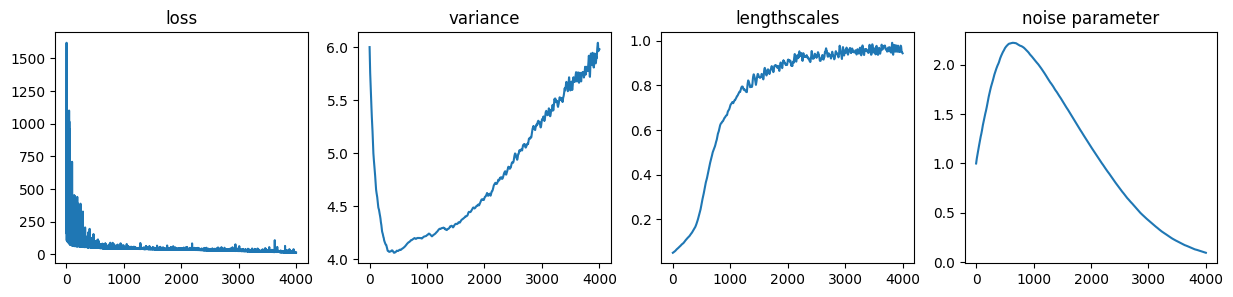

In [349]:
visualise_training(vgp2_res['losses'], vgp2_res['variances'], vgp2_res['lengthscales'], vgp2_res['noises'])

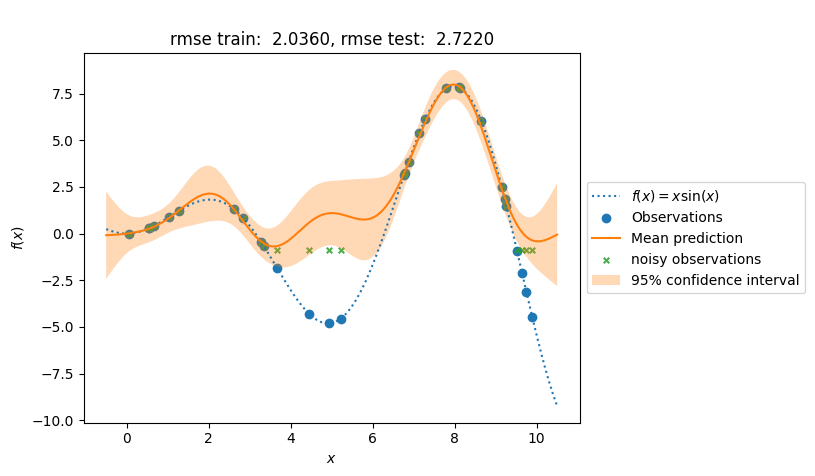

In [350]:
visualise_results(vgp2, censored=y_train_censored)

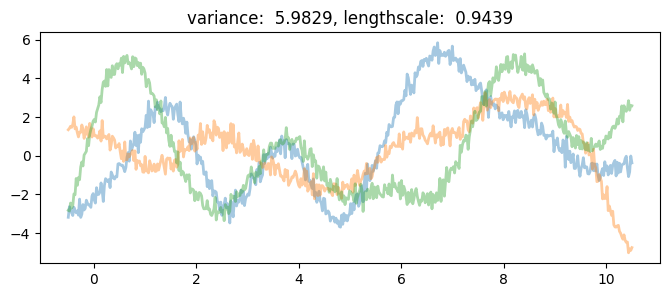

In [351]:
visualise_trajectories(vgp2, fcn_key_, 3)

In [352]:
kernel3 = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(var_),
    lengthscale=torch.tensor(lengthscale_))

# own implemented Gaussian likelihood
vgp3 = VariationalGP(torch.Tensor(X_train), torch.Tensor(y_train_censored), kernel=kernel3, likelihood=likelihood3, whiten=True, jitter=1e-06)

In [353]:
vgp3_res = optimise(vgp3, num_steps=4000, MeanFieldElbo=False)

100%|██████████| 4000/4000 [00:23<00:00, 173.17it/s]


variance =  3.989124
lengthscale =  0.905054
noise =  0.202140


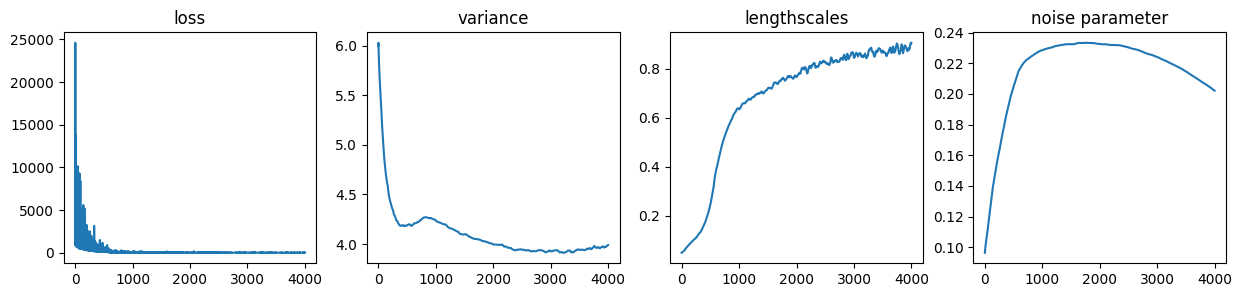

In [354]:
visualise_training(vgp3_res['losses'], vgp3_res['variances'], vgp3_res['lengthscales'], vgp3_res['noises'])

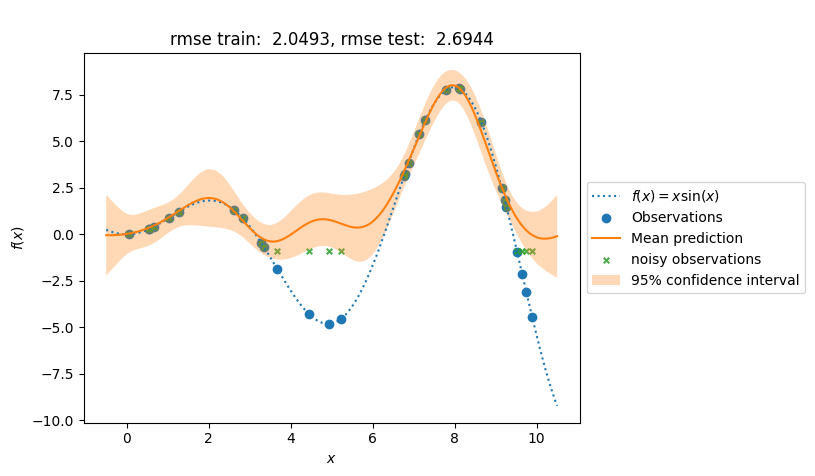

In [357]:
visualise_results(vgp3, censored=y_train_censored)

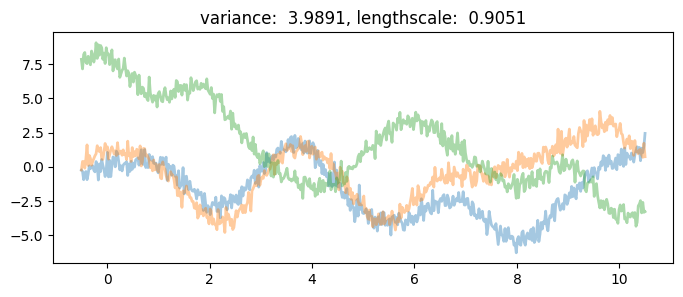

In [356]:
visualise_trajectories(vgp3, fcn_key_, 3)